In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
import os
import shutil
import requests
import logging
from datetime import datetime
from functools import cache
import uuid

from mpl_toolkits.basemap import Basemap

from OSMPythonTools.overpass import Overpass
from OSMPythonTools.overpass import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder

import logging


## OSM Data Pipeline

In [3]:

class OSMDataPipeline:
    # Data path variables
    SUB_OSM_DATA_PATH = "data_store/osm_data"
    OSM_DATA_PATH = os.path.abspath(SUB_OSM_DATA_PATH) + "/"

    # Flow variables
    TIMEOUT = 300

    # Initialize overpass and nominat objects
    nominatim = Nominatim()
    overpass = Overpass()

    def __init__(self, area_name="Hamburg"):
        self.area_name = area_name

        self.save_json_file = True
        self.save_csv_file = True

        
    ############################
    ##### HELPER FUNCTIONS #####
    ############################

    # DOWNLOAD DATA
    def download_data(self, query: str, data_type) -> dict:
        response = self.overpass.query(query, timeout=self.TIMEOUT)
        data = response.toJSON()

        # Save the data to a JSON file
        with open(self.OSM_DATA_PATH + f"{data_type}_data.json", 'w') as f:
            json.dump(data, f)
            print(f"Data saved to {self.OSM_DATA_PATH}{data_type}_data")
        
        return data
    
    # SAVE DATA TO CSV AND JSON
    def data_save_helper(self, json_data: dict, filterd_list: list, file_name: str):
        # save data as json
        if self.save_json_file:
            dir_exists = os.path.exists(f"{self.OSM_DATA_PATH}/{self.area_name.lower()}/json_raw_data_files")
            if not dir_exists:
                os.makedirs(f"{self.OSM_DATA_PATH}/{self.area_name.lower()}/json_raw_data_files")

            with open(f"{self.OSM_DATA_PATH}/{self.area_name.lower()}/json_raw_data_files/{file_name.lower()}.json", "w") as save_file:
                json.dump(json_data, save_file)
                print(f"Saved as json file successfully!  check '{file_name.lower()}.json' file.")


        # save data as csv
        if self.save_csv_file:
            # check if directory already exists
            dir_exists = os.path.exists(f"{self.OSM_DATA_PATH}/{self.area_name.lower()}")
            if not dir_exists:
                os.makedirs(f"{self.OSM_DATA_PATH}/{self.area_name.lower()}")

            # Keys: ['version', 'generator', 'osm3s', 'elements']
            df = pd.DataFrame(filterd_list) # filterd is a list of dics with keys ['type', 'id', 'lat', 'lon']
            
            try:
                # sort dataframe by way_id if way_id is in dataframe
                df = df.sort_values("way_id")
                    
            except KeyError as err:
                print(f'no way_id in dataset of file: {file_name}')

            df.to_csv(f'{self.OSM_DATA_PATH}/{self.area_name.lower()}/{file_name.lower()}.csv')
            print(f"Saved as csv file successfully!  check {file_name.lower()}.csv file.")


    ##########################
    ##### DATA FUNCTIONS #####
    ##########################

    # WIND TURBINE DATA
    def get_area_windturbin_data(self):
        query = f"""
        area[name="{self.area_name}"]->.a;
        (
        nwr["power"="plant"]["plant:source"="wind"];
        );
        out body;
        >;
        out skel qt;
        """

        json_data = self.download_data(query, "wind_turbine")

        node_list = [elm for elm in json_data['elements'] if elm['type'] == 'node']
        way_list = [elm for elm in json_data['elements'] if elm['type'] == 'way']

        # for index, elm in enumerate(way_list):
        #     inline_id = 0
        #     for id in elm['nodes']:
        #         inline_id += 1
        #         for line_elm_dict in node_list:
        #             if line_elm_dict['id'] == id:
        #                 try:
        #                     tag_keys = elm['tags'].keys()
        #                     line_elm_dict['way_id'] = elm['id']
        #                     line_elm_dict['windTurbineID'] = inline_id
        #                     for key in tag_keys:
        #                         line_elm_dict[f'{key}'] = elm['tags'][f'{key}']
        #                 except KeyError as err:
        #                     print(f"No tag: {err}")
        #                     # Implement error handling here (e.g., logging)
        #                 break  # stop iteration if id is found

        # self.data_save_helper(json_data, node_list, f"border_coordinates_{self.area_name}")

        return node_list, way_list, json_data


    # WIND PARK DATA
    def get_germany_windpark_data(self):
        query = f"""
        [out:json][timeout:{self.TIMEOUT}];
        {{geocodeArea:{self.area_name}}}->.searchArea;
        (
        nwr["power"="plant"]["plant:source"="wind"](area.searchArea);
        );
        (._;>;);
        out center qt;
        """

        json_data = self.download_data(query, "wind_turbine")

        node_list = [elm for elm in json_data['elements'] if elm['type'] == 'node']
        way_list = [elm for elm in json_data['elements'] if elm['type'] == 'way']

        for index, elm in enumerate(way_list):
            inline_id = 0
            for id in elm['nodes']:
                inline_id += 1
                for line_elm_dict in node_list:
                    if line_elm_dict['id'] == id:
                        try:
                            tag_keys = elm['tags'].keys()
                            line_elm_dict['way_id'] = elm['id']
                            line_elm_dict['windTurbineID'] = inline_id
                            for key in tag_keys:
                                line_elm_dict[f'{key}'] = elm['tags'][f'{key}']
                        except KeyError as err:
                            print(f"No tag: {err}")
                            # Implement error handling here (e.g., logging)
                        break  # stop iteration if id is found

        self.data_save_helper(json_data, node_list, f"border_coordinates_{self.area_name}")

        return node_list




In [4]:
# Example usage
pipeline = OSMDataPipeline(area_name="Hamburg")
node_list, way_list, json_data = pipeline.get_area_windturbin_data()


Data saved to /Users/andreaszwikirsch/Desktop/01Uni/03BA_WS22/python_scripts/windpark_clustering/data_store/osm_data/wind_turbine_data


In [41]:
node_list[10].keys()

dict_keys(['type', 'id', 'lat', 'lon'])

In [40]:
way_list[10].keys()

dict_keys(['type', 'id', 'nodes', 'tags'])

In [38]:
for index, way_elm in enumerate(way_list):
    if "nodes" in way_elm.keys():
        

[1342948772,
 1936966119,
 1936965062,
 1936965268,
 1936966034,
 1342948776,
 1342948745,
 1937014448,
 1937014570,
 1937014314,
 1937014172,
 1937014187,
 1937014143,
 1937014538,
 1937014197,
 1937014408,
 1937014327,
 1937014156,
 1937014374,
 1937014404,
 1937014510,
 1937014497,
 1937014220,
 1937014280,
 1937014325,
 1342948832,
 1937014462,
 1342948833,
 1937014360,
 1426434208,
 1937014557,
 1937014348,
 1937014392,
 1342948799,
 1342948772]

In [6]:
way_cache = {}
no_man_made_numb = 0
no_tag_type_list = []
types_list = []
errors_logger = {"tags": 0, "nodes": 0, "way_id": 0, "category": 0, "tags": 0}
no_tag_list = []
for index, way_elm in enumerate(way_list):
    
    try:
        way_cache['way_id'] = way_elm["id"]
    except KeyError as err:
        errors_logger["way_id"] += 1
        types_list.append(way_elm['type'])
        print(f"KeyError way_id (Type: {way_elm['type']}): {err} [{errors_logger['way_id']}/{index}]")
        continue

    try:
        way_cache['nodes'] = way_elm["nodes"]
    except KeyError as err:
        errors_logger["nodes"] += 1
        types_list.append(way_elm['type'])
        print(f"KeyError nodes (Type: {way_elm['type']}): {err} [{errors_logger['nodes']}/{index}]")
        continue

    try:
        temp_tags = way_elm['tags']
        if 'seamark:production_area:category' in temp_tags:
            way_cache['seamark:production_area:category'] = temp_tags['seamark:production_area:category']
        else:
            types_list.append(way_elm['type'])
        
    except KeyError as err:
        temp_tags = {}
        types_list.append(way_elm['type'])
        if str(err) == "'tags'":
            errors_logger["tags"] += 1
            print(f"KeyError tags (Type: {way_elm['type']}): {err} [{errors_logger['tags']}/{index}]")
        else:
            errors_logger["category"] += 1
            print(f"KeyError category (Type: {way_elm['type']}): {err} [{errors_logger['category']}/{index}]")

        no_tag_list.append(way_elm)

        continue

print(set(types_list))
print(errors_logger)
    

KeyError tags (Type: way): 'tags' [1/763]
KeyError tags (Type: way): 'tags' [2/764]
KeyError tags (Type: way): 'tags' [3/765]
KeyError tags (Type: way): 'tags' [4/766]
KeyError tags (Type: way): 'tags' [5/767]
KeyError tags (Type: way): 'tags' [6/768]
KeyError tags (Type: way): 'tags' [7/769]
KeyError tags (Type: way): 'tags' [8/770]
KeyError tags (Type: way): 'tags' [9/771]
KeyError tags (Type: way): 'tags' [10/772]
KeyError tags (Type: way): 'tags' [11/773]
KeyError tags (Type: way): 'tags' [12/774]
KeyError tags (Type: way): 'tags' [13/775]
KeyError tags (Type: way): 'tags' [14/776]
KeyError tags (Type: way): 'tags' [15/777]
KeyError tags (Type: way): 'tags' [16/778]
KeyError tags (Type: way): 'tags' [17/779]
KeyError tags (Type: way): 'tags' [18/780]
KeyError tags (Type: way): 'tags' [19/781]
KeyError tags (Type: way): 'tags' [20/782]
KeyError tags (Type: way): 'tags' [21/783]
KeyError tags (Type: way): 'tags' [22/784]
KeyError tags (Type: way): 'tags' [23/785]
KeyError tags (Type:

In [7]:
count = len([node for node in node_list if 'tags' in node])
print(count)


4


In [8]:
len(node_list)

219610

In [9]:
import pandas as pd

df_wind = pd.DataFrame(node_list, columns=['type', 'id', 'lat', 'lon'])
print(df_wind)

        type           id        lat         lon
0       node   1593484268  50.880672    2.489143
1       node   4870746021  35.486032  133.441469
2       node   8285398380 -34.010729   24.880771
3       node   9768723806  47.193795   42.544470
4       node   9695998304 -44.037272 -176.383337
...      ...          ...        ...         ...
219605  node  11308086509  52.659475  156.242994
219606  node  11308086510  52.656689  156.244952
219607  node  11308086511  52.656544  156.245027
219608  node  11308086512  52.656592  156.245280
219609  node  11308086513  52.656737  156.245204

[219610 rows x 4 columns]


In [28]:
SLICE_DATA = False
if SLICE_DATA:
    lat_min, lat_max = 52.7, 53.35 # use for small slice north east of germany
    lon_min, lon_max = 12, 12.8 # use for small slice north east of germany
    PLOT_DPI = 700
else:
    lat_min, lat_max = 47.3, 55.2 # use for all of germany
    lon_min, lon_max = 5.5, 16.0 # use for all of germany
    PLOT_DPI = 1500

In [29]:
df_wind.head()

,type,id,lat,lon
0,node,1593484268,50.880672,2.489143
1,node,4870746021,35.486032,133.441469
2,node,8285398380,-34.010729,24.880771
3,node,9768723806,47.193795,42.544470
4,node,9695998304,-44.037272,-176.383337


In [ ]:
df_sliced = df_wind[(df_wind['lat'] >= lat_min) & (df_wind['lat'] <= lat_max) & (df_wind['lon'] >= lon_min) & (df_wind['lon'] <= lon_max)]


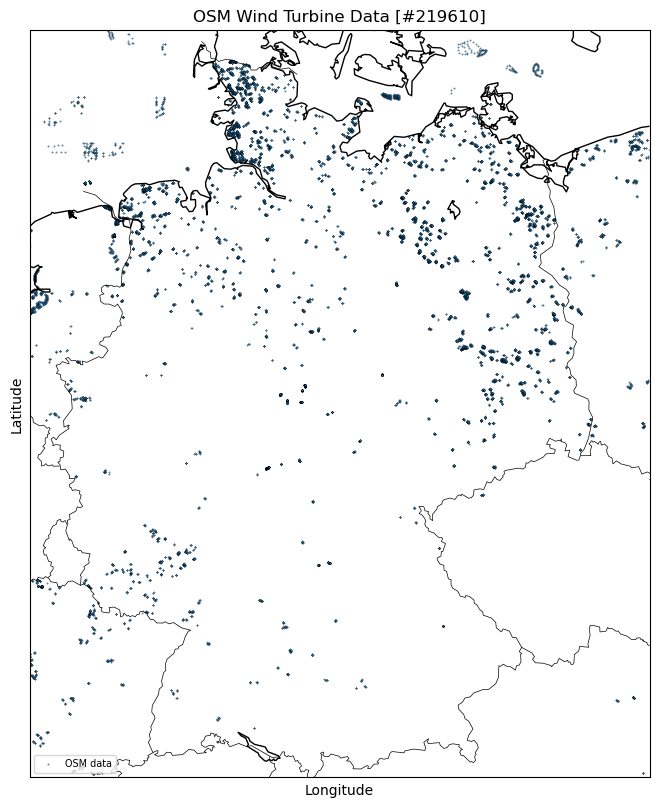

In [30]:
def netzebene_plot(df):

    # Calculate aspect ratio
    image_width_to_height_ratio = (lon_max - lon_min) / (lat_max - lat_min)

    # Create a figure with the same aspect ratio
    fig, ax = plt.subplots(figsize=(8, 8 * image_width_to_height_ratio))

    # Set the background color as transparent
    # fig.patch.set_alpha(0)
    # ax.patch.set_alpha(0)

    # Create a Basemap instance that aligns with Google Maps projection and bounds
    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, resolution='i', ax=ax)

    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/long to map projection coordinates
    x, y = m(df.lon, df.lat)

    scatter_legends = []
    scatter = m.scatter(x, y, alpha=0.7, s=1, label="OSM data", edgecolors='black', linewidth=0.2)
    scatter_legends.append(scatter)

    # scatter_legends = []
    # for category, color in color_map.items():
    #     subset = df[df['Spannungsebene_Category'] == category]
    #     temp_label = f"[#{subset.shape[0]}] - {category}" if subset.shape[0] != 0 else f"{category}"
    #     x_temp, y_temp = m(subset.lon, subset.lat)
    #     scatter = m.scatter(x_temp, y_temp, alpha=0.7, color=color, s=1, label=temp_label, edgecolors='black', linewidth=0.2)
    #     scatter_legends.append(scatter)
    
    # Setting labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'OSM Wind Turbine Data [#{df.shape[0]}]')
    ax.grid(True)
    ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')

    plot_id = str(uuid.uuid4())
    # plt.savefig(plot_save_path + "wind_ms_all_data_plot.png", dpi=plot_save_resolution, bbox_inches='tight', transparent=True)
    plt.savefig(pipeline.OSM_DATA_PATH + f"wind_ms_all_data_plot_{plot_id}.png", dpi=PLOT_DPI, bbox_inches='tight')
    
    plt.show()


# # RUN NETZEBENE PLOT FUNCTION
netzebene_plot(df_wind)